In [1]:
from spynnaker_external_devices_plugin.pyNN.connections\
    .spynnaker_live_spikes_connection import SpynnakerLiveSpikesConnection

In [2]:
# plotter in python
%matplotlib notebook
import matplotlib.pyplot as plt

import time as my_time
import numpy

In [3]:
# Reads the arrays generated on the simulator side to convert from SpiNNaker to BEE
from_spinnaker_exc2bee = numpy.load('from_spinnaker_exc2bee.npy')
from_spinnaker_inh2bee = numpy.load('from_spinnaker_inh2bee.npy')

# Reads the arrays generated on the simulator side to convert from BEE to SpiNNaker
from_bee2spinnaker = numpy.load('from_bee2spinnaker.npy')

In [4]:
n_neurons = from_bee2spinnaker.shape[1]

number_of_liquids = from_bee2spinnaker.shape[0]

In [5]:
# SpynnakerLiveSpikesConnection(self, receive_labels=None, send_labels=None, local_host=None, local_port=19999)

# Set up the live connection for sending and receiving spikes
live_spikes_connection = SpynnakerLiveSpikesConnection(
    receive_labels=["LSM_EXC","LSM_INH"], 
    send_labels=["spike_injector"],
    local_port=12346)

In [6]:
# Create an initialisation method
def init_pop(label, n_neurons, run_time_ms, machine_timestep_ms):
    print "{} has {} neurons".format(label, n_neurons)
    print "Simulation will run for {}ms at {}ms timesteps".format(run_time_ms, machine_timestep_ms)

In [7]:
received_spikes = {'LSM_EXC':[],'LSM_INH':[]}
def receive_spikes(label, time, neuron_ids):
    received_spikes[label].append([time,neuron_ids])
#     my_time.sleep(feedback_delay)
#     live_spikes_connection.send_spikes("spike_injector", neuron_ids)
#     for neuron_id in neuron_ids:
#         print "Received spike at time", time, "from", label, "-", neuron_id

In [8]:
initial_array = numpy.arange(n_neurons*number_of_liquids)
# numpy.random.shuffle(initial_array)
def started(label, sender):
    print "{}=>Simulation has started!".format(label)
    sender.send_spikes("spike_injector", initial_array[range(0,30)+range(700,730)])

In [9]:
# Here is the best place to pause SpiNNaker if it is necessary to wait until
# something on the external machine is ready.
# After the function below returns, SpiNNaker is going to ack the simulation start
# and the function supplied for add_start_callback will be called.
def database_callback_function(something):
    # my_time.sleep(50)
    print "database callback..."
    # print dir(something)

In [10]:
live_spikes_connection.add_receive_callback("LSM_EXC", receive_spikes)
live_spikes_connection.add_receive_callback("LSM_INH", receive_spikes)

live_spikes_connection.add_init_callback("LSM_EXC", init_pop)
live_spikes_connection.add_init_callback("LSM_INH", init_pop)
live_spikes_connection.add_init_callback("spike_injector",init_pop)

live_spikes_connection.add_database_callback(database_callback_function)

live_spikes_connection.add_start_callback("spike_injector",started)

spike_injector has 3000 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
LSM_EXC has 2400 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
LSM_INH has 600 neurons
Simulation will run for 1000.0ms at 2.0ms timesteps
database callback...
spike_injector=>Simulation has started!


spynnaker database connection for None:12346: <Thread(start callback thread for live_event_connection12346:0.0.0.0, initial daemon)>.start(): starting thread
start callback thread for live_event_connection12346:0.0.0.0: <Thread(start callback thread for live_event_connection12346:0.0.0.0, started daemon 4566462464)>.__bootstrap(): thread started
start callback thread for live_event_connection12346:0.0.0.0: <Thread(start callback thread for live_event_connection12346:0.0.0.0, started daemon 4566462464)>.__bootstrap(): normal return


In [11]:
times = []
spikes = []

for lsm_i in range(number_of_liquids):
    times.append([])
    spikes.append([])
    
# If there are spikes, plot using matplotlib
if len(received_spikes['LSM_EXC']) != 0 or len(received_spikes['LSM_INH']) != 0:
    if len(received_spikes['LSM_EXC']) != 0:
        for i,j in received_spikes['LSM_EXC']:
            for k in j:
                lsm_i, idx = from_spinnaker_exc2bee[int(k)]
                (times[lsm_i]).append(i)
                (spikes[lsm_i]).append(idx)
    if len(received_spikes['LSM_INH']) != 0:
        for i,j in received_spikes['LSM_INH']:
            for k in j:
                lsm_i, idx = from_spinnaker_inh2bee[int(k)]
                (times[lsm_i]).append(i)
                (spikes[lsm_i]).append(idx)
else:
    print "No spikes received"

<IPython.core.display.Javascript object>


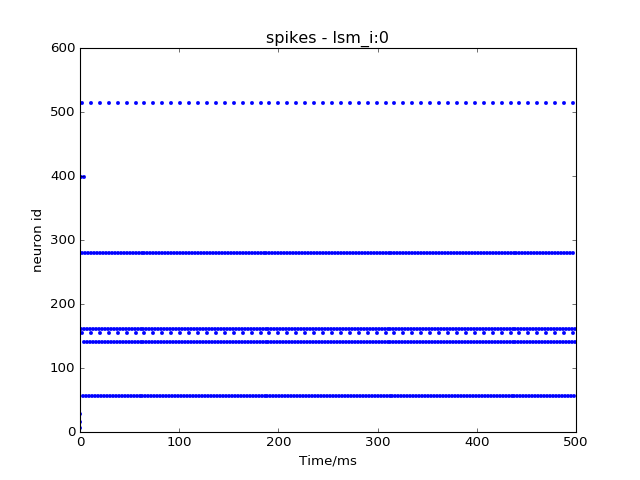

<IPython.core.display.Javascript object>


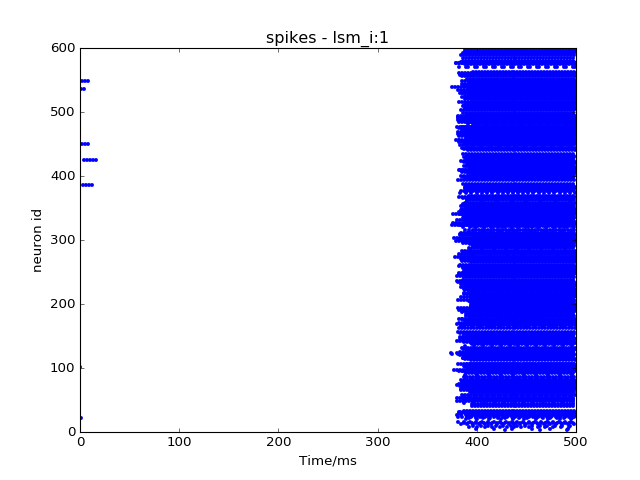

In [13]:
for lsm_i in range(number_of_liquids):
    if len(times[lsm_i]):
        plt.figure()
        plt.plot(times[lsm_i],spikes[lsm_i],'.')
        plt.ylabel('neuron id')
        plt.xlabel('Time/ms')
        plt.title('spikes - lsm_i:'+str(lsm_i))
        plt.show()